# Download and tabulate H2 equation of state
Derived from Chabrier, Mazevet, and Soubiran (2019)      
Article here: https://iopscience.iop.org/article/10.3847/1538-4357/aaf99f       
Data here: https://perso.ens-lyon.fr/gilles.chabrier/DirEOS/

In [1]:
import os
import numpy as np
from thermotools import get_inpdir, get_gendir, empty_dir
from thermotools.plot import *
from thermotools.util import download, untar
from scipy.interpolate import griddata

In [2]:
datdir = os.path.join(get_gendir(), "cms19", "dat")
empty_dir(datdir)
pltdir = os.path.join(get_gendir(), "cms19", "plt")
empty_dir(pltdir)
webdir = os.path.join(get_gendir(), "cms19", "web")
empty_dir(webdir)

First, we will download the data and untar it

In [3]:
url      = "https://osf.io/download/mdcvt/"
tar_file = os.path.join(webdir, "DirEOS2019.tar.gz")

download(url, tar_file)
untar(tar_file, webdir)

Download file from https://osf.io/download/mdcvt/
    Done
Untarring /dataserver/users/formingworlds/nicholls/ThermoTools/generated/cms19/web/DirEOS2019.tar.gz
    Done


Read the data into memory

In [4]:
raw_file = os.path.join(webdir, "DirTABLES-EOS2019", "TABLE_H_TP_v1")
data = np.loadtxt(raw_file).T
tmp_raw = 10**np.array(data[0])
prs_raw = np.array(data[1]) + 9  # log Pa
rho_raw = np.array(data[2]) + 3  # log kg/m^3

print("    tmp: %+7.2f to %+.2f, %d points"%(np.amin(tmp_raw), np.amax(tmp_raw), len(tmp_raw)))
print("log prs: %+7.2f to %+.2f, %d points"%(np.amin(prs_raw), np.amax(prs_raw), len(prs_raw)))
print("log rho: %+7.2f to %+.2f, %d points"%(np.amin(rho_raw), np.amax(rho_raw), len(rho_raw)))

    tmp: +100.00 to +100000000.00, 53361 points
log prs:   +0.00 to +22.00, 53361 points
log rho:   -6.00 to +9.09, 53361 points


Demonstrate interpolation at low resolution

Number of points = 3500


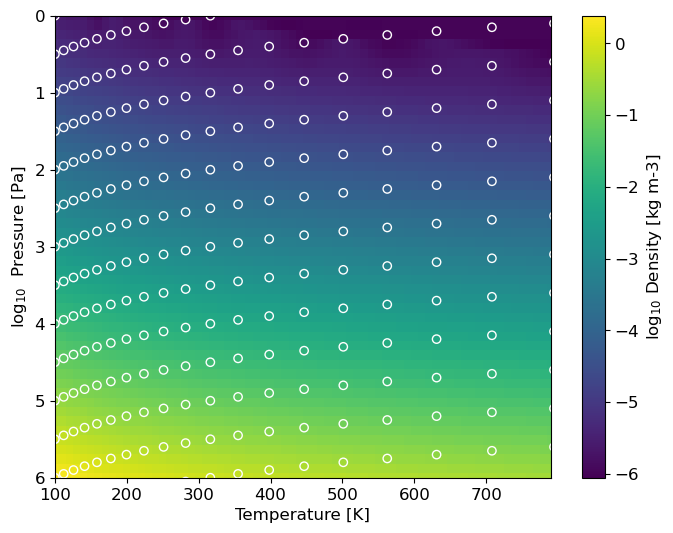

In [5]:
# target axes
t_eval = np.arange(  100,  800, 10.0)   # K
p_eval = np.linspace(0,   6,    50)     # log Pa
print("Number of points = %g"%(len(p_eval)*len(t_eval),))

# interpolate
ti,pi = np.meshgrid(t_eval,p_eval)
zi = griddata((tmp_raw,prs_raw),rho_raw,(ti,pi), method='cubic', rescale=True)

# down-sample original data
s = 10
tmp_ref = tmp_raw[::s]
prs_ref = prs_raw[::s]
rho_ref = rho_raw[::s]

# plot
norm = mpl.colors.Normalize(vmin=np.amin(zi), vmax=np.amax(zi))
cmap = "viridis"
fig,ax = plt.subplots(1,1, figsize=(8,6))
sm = ax.pcolormesh(ti, pi, zi, norm=norm)
ax.scatter(tmp_ref, prs_ref, c=rho_ref, norm=norm, cmap=cmap, edgecolors='white')
ax.set(ylabel=r"log$_{10}$  Pressure [Pa]", xlabel="Temperature [K]")
ax.set_xlim(left=t_eval[0], right=t_eval[-1])
ax.set_ylim(top=p_eval[0], bottom=p_eval[-1])
fig.colorbar(sm, label=r"log$_{10}$ Density [kg m-3]")
plt.show()
fig.savefig(os.path.join(pltdir, "demo_lowres.png"), dpi=200, bbox_inches='tight')

High resolution calculation

In [6]:
t_eval = np.arange(  101,  4000, 0.8)   # K
p_eval = np.linspace(0,   10,    225)     # log Pa
print("Number of points = %.2e"%(len(p_eval)*len(t_eval),))

Number of points = 1.10e+06


In [7]:
ti,pi = np.meshgrid(t_eval,p_eval)
zi = griddata((tmp_raw,prs_raw),rho_raw,(ti,pi),method='cubic', rescale=True)

In [8]:
print(zi)
print("Contains NaN: "+str(np.any(np.isnan(zi))))

[[-5.52231681 -5.52913335 -5.53592777 ... -6.         -6.
  -6.        ]
 [-5.49701855 -5.50305017 -5.50906599 ... -6.         -6.
  -6.        ]
 [-5.4697659  -5.47519092 -5.48054346 ... -6.         -6.
  -6.        ]
 ...
 [ 2.47771632  2.4777055   2.47769441 ...  2.27407332  2.27405054
   2.27402777]
 [ 2.49098157  2.49097227  2.49096293 ...  2.29955641  2.29953519
   2.29951396]
 [ 2.50439987  2.50439175  2.5043836  ...  2.32484652  2.32482674
   2.32480696]]
Contains NaN: False


In [9]:
print("Saving data")
X = np.array([ti.flat, pi.flat, zi.flat]).T
fpath = os.path.join(datdir, "H2.csv")
np.savetxt(fpath, X, fmt="%.9e", header="T [K], log P [Pa], log rho [kg/m^3]", delimiter=',')
print("    Done")

Saving data
    Done


Making plot
    Done


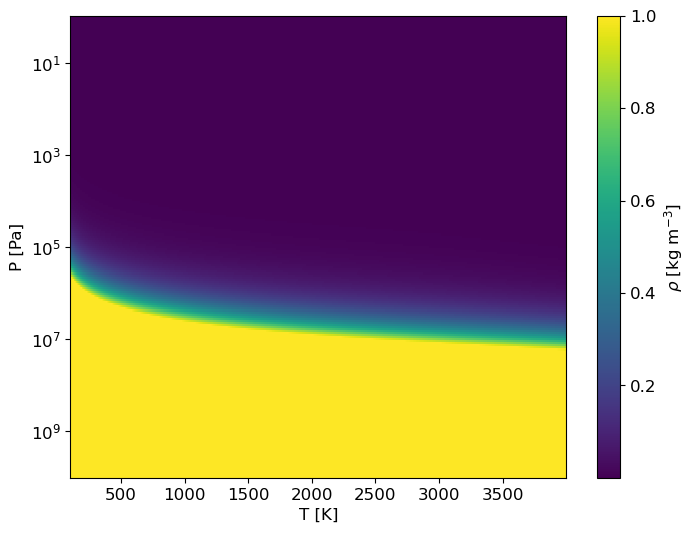

In [10]:
print("Making plot")

# plot
fig, ax = plt.subplots(1, 1, figsize=(8,6))

ax.invert_yaxis()
ax.set_yscale('log')
ax.set_xlabel('T [K]')
ax.set_ylabel('P [Pa]')

R = 10**zi
im = ax.pcolormesh(ti, 10**pi, R, cmap='viridis', norm='linear', vmax=1)
fig.colorbar(im, label=r'$\rho$ [kg m$^{-3}$]')
fig.savefig(os.path.join(pltdir, "H2_rho.png"), bbox_inches='tight', dpi=210)

print("    Done")